<a href="https://colab.research.google.com/github/ahmergit/projects/blob/main/Prompt_Generater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture --no-stderr
%pip install --quiet langgraph -U langchain_google_genai


In [2]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [17]:
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model = "gemini-1.5-flash",
    api_key= GOOGLE_API_KEY,
    temperature=0.1,
)

In [12]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4268684a-f782-49f0-b72e-b148bc2f8549-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [21]:
from typing import List
from langchain_core.messages import SystemMessage
from pydantic import BaseModel
from langgraph.graph import StateGraph, START,END


In [14]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""

In [15]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [16]:
def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]

In [18]:
llm_with_tool = llm.bind_tools([PromptInstructions])

In [19]:
def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [33]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, AIMessage) and not m.tool_calls :
             other_msgs.append(m)
        elif isinstance(m, HumanMessage): # Separate condition for HumanMessage
            other_msgs.append(m)
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [23]:
from typing import Literal



def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [24]:
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [25]:
from langgraph.checkpoint.memory import MemorySaver


In [31]:
memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)
workflow.add_node("add_tool_message", add_tool_message)
workflow.add_conditional_edges("info", get_state, ["add_tool_message", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

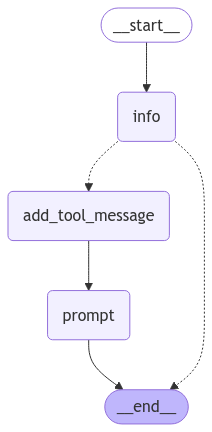

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": 1}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): generate prompt for email compose. candidate name: Ahmer, company: ABC, Job_title : building ai_agent, skill: python and working to build ai agent using langgraph technology. Now Constraints: prompt should 300 words, using professional language, and i have good in communication skill,  i have good in full-stack developer using fastapi.
User (q/Q to quit): generate prompt for email compose. candidate name: Ahmer, company: ABC, Job_title : building ai_agent, skill: python and working to build ai agent using langgraph technology. Now Constraints: prompt should 300 words, using professional language, and i have good in communication skill,  i have good in full-stack developer using fastapi.
================================== Ai Message ==================================

Here's a prompt template designed to generate a job application email based on your specifications.  Remember to replace the bracketed placeholders with the actual values.

```
Write a professional emai